In [274]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [275]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [276]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'villagepotato',
     shuffle=True,
     image_size=(IMAGE_SIZE, IMAGE_SIZE),
     batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [277]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [278]:
for image, label in dataset.take(1):
    print(label)
    print(label.numpy())
    print(image.shape)
    print(image[0].shape)

tf.Tensor([0 0 0 0 0 1 2 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 2 0 0 1 1 1 1 0 1], shape=(32,), dtype=int32)
[0 0 0 0 0 1 2 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 2 0 0 1 1 1 1 0 1]
(32, 256, 256, 3)
(256, 256, 3)


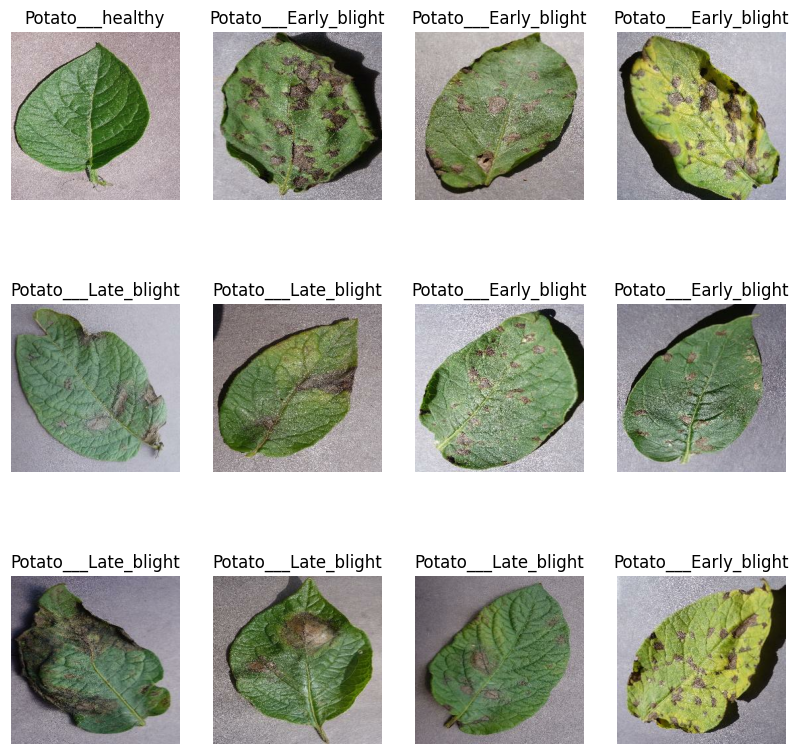

In [279]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        # print(label.numpy())
        plt.axis('off')
        plt.title(class_name[label[i].numpy()])

80% => TRAINING
20% => (10% VALIDATION, 10% TEST)

In [280]:
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
len(train_ds), len(test_ds)

(54, 14)

In [281]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [282]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)
len(val_ds), len(test_ds)

(6, 8)

In [283]:
def get_dataset_partitions_df(ds, train_split = 0.8, test_split=0.1, valid_split=0.1, shuffle=True, shuffle_size=2000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12 )
    train_size = int(train_split*ds_size)
    valid_size = int(valid_split*ds_size)

    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).skip(valid_size)
    valid_ds = dataset.skip(valid_size).take(valid_size)
    return train_ds, valid_ds, test_ds

In [284]:
train_ds, valid_ds, test_ds = get_dataset_partitions_df(dataset)

In [285]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize and rescale the image

In [286]:
resize_rescale = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [287]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])